In [1]:
# 在本机未更新至2.0.8的情况下，使用vnpy2.0.8的回测逻辑
import sys
import os
from pathlib import Path
new_version_path = Path(os.getenv('VNPY2.0.8'))
sys.path.insert(0, str(new_version_path))

import pandas as pd
import matplotlib.pyplot as plt
import pprint
from utility import get_output_folder, get_output_path
from research_backtest import get_hot_start, run_research_backtest, batch_run, analyze_multi_bt, str_to_params, params_to_str
from datetime import datetime

plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 30)


c:\vnstudio\lib\site-packages\pymysql\cursors.py:170: Warning: (3090, "Changing sql mode 'NO_AUTO_CREATE_USER' is deprecated. It will be removed in a future release.")
  result = self._query(query)


2.0.8


#### 单品种回测及成交记录分析

<IPython.core.display.Javascript object>


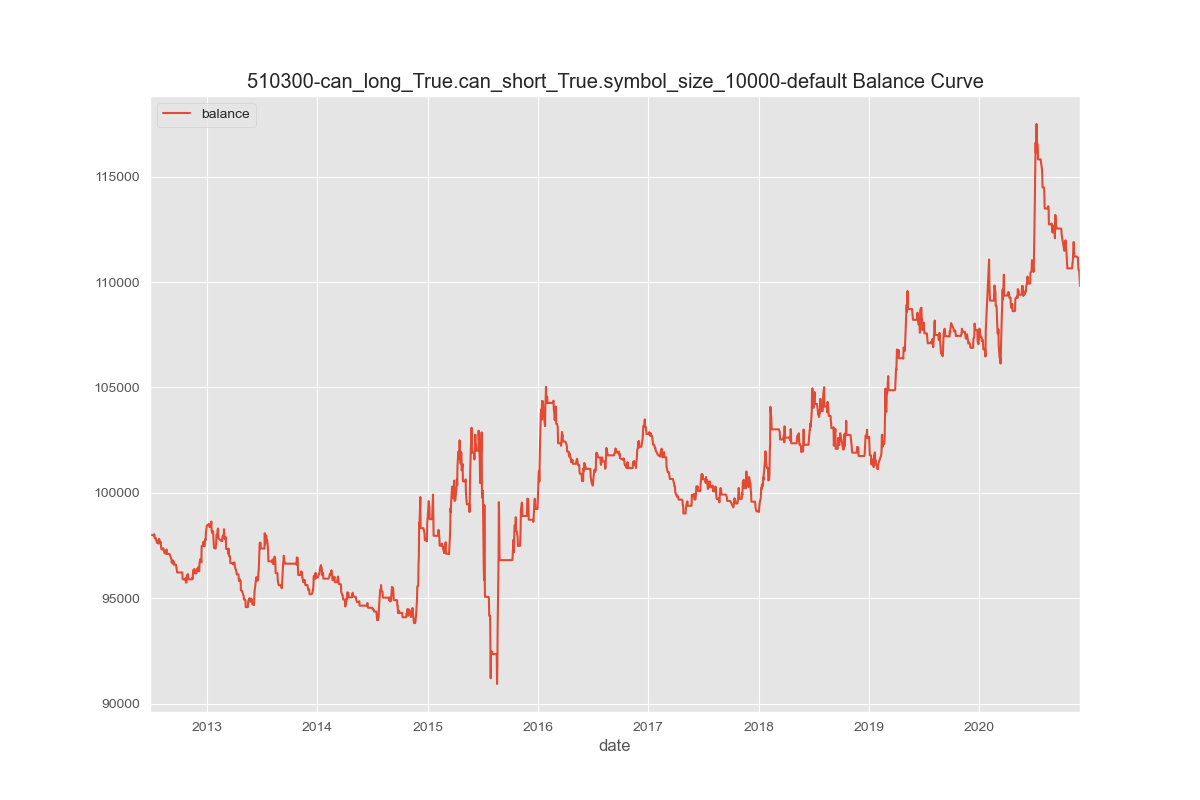

turtle_exit_ma.510300.can_long_True.can_short_True.symbol_size_10000.default-回测完成
can_long_True.can_short_True.symbol_size_10000
{'annual_return': 1.4093567251461994,
 'capital': 98000,
 'commission': 0.0,
 'commodity': '510300',
 'daily_trade_count': 0.25292397660818716,
 'day_end_balance': 109809.0,
 'day_max_ddpercent': -11.792210311878547,
 'day_max_drawdown': -12156.0,
 'end_date': datetime.date(2020, 11, 30),
 'net_pnl': 11808.999999999987,
 'pos_duration': 117.74903474903472,
 'return_drawdown_ratio': 1.0218610151365584,
 'sharpe_ratio': 0.24221628790888042,
 'slippage': 15570.0,
 'start_date': datetime.date(2012, 6, 26),
 'total_return': 12.050000000000004,
 'trade_count': 259,
 'trade_end_balance': 110579.00000000001,
 'trade_max_ddpercent': -9.46283787095952,
 'trade_max_drawdown': -9652.0,
 'win_loss_pnl_ratio': 2.1555047128825273,
 'winning_rate': 0.3552123552123552}


510300.SSE 	 2012-07-09 14:00:00 	 short 	 2.164 	 1
510300.SSE 	 2012-07-12 13:00:00 	 long 	 2.174 	 1
T



510300.SSE 	 2020-11-05 09:30:00 	 long 	 4.92 	 1
510300.SSE 	 2020-11-11 14:00:00 	 short 	 4.982 	 1
Trade Pnl: 0.06200000000000028 	 Cum Pnl: 2.8689000000000027


510300.SSE 	 2020-11-23 13:00:00 	 long 	 5.074 	 1
510300.SSE 	 2020-11-25 13:00:00 	 short 	 5.0169999999999995 	 1
Trade Pnl: -0.057000000000000384 	 Cum Pnl: 2.8119000000000023


510300.SSE 	 2020-11-30 09:30:00 	 long 	 5.105 	 1


In [2]:
%matplotlib notebook

commodity = '510300'
# start = get_hot_start(commodity)
start = datetime(2012, 1, 1)
end = datetime(2020, 12, 1)
interval = '1h'
# capital = 1000000
capital = None

strategy_name = 'turtle_exit_ma'
# params_dict = {
#     'is_say_log': True,
#     'trailing_percent': 5,
#     'rsi_entry': 30
# }

params_dict = {
    'can_long': True,
    'can_short': True,
}


# params_dict = {
#     'entry_window': 80,
#     'exit_window': 40,
#     'risk_percent': 0.002,
#     'risk_capital': 1000000
    #     'sl_multiplier': 3
# }

# params_dict = {
#     'boll_window': 80,
#     'boll_dev': 2,
#     'risk_percent': 0.002,
#     'risk_capital': 1000000,
# }

res_dict = run_research_backtest(commodity,
                                 start,
                                 end,
                                 strategy_name=strategy_name,
                                 strategy_params=params_dict,
                                 empty_cost=False,
                                 cost_multiple=2,
                                 trade_output=True,
                                 curve_output=True,
                                 capital=capital,
                                 interval=interval,
                                 keep_last_open=True)

params_str = params_to_str(params_dict)
print(params_str)
pprint.pprint(res_dict)
print('\n')

filename = f'{strategy_name}.{commodity}.{params_str}.default.trades.csv'
trades = pd.read_csv(get_output_path(filename, 'trades'))
cum_pnl = 0
for idx, trade in trades.iterrows():
    print(
        f"{trade.vt_symbol} \t {trade.datetime} \t {trade.direction} \t {trade.price} \t {trade.volume}"
    )
    if trade.offset == "open":
        entry = trade.price
        volume = trade.volume if trade.direction == "long" else (-1 * trade.volume)

    if trade.offset == "close":
        pnl = (trade.price - entry) * volume
        cum_pnl += pnl
        print(f"Trade Pnl: {pnl} \t Cum Pnl: {cum_pnl}")
        print("=" * 60)
        print("\n")

### 统计多品种回测结果

因为jupyter notebook windows版本不支持多进程，所以回测用research_backtest.py

In [ ]:
note = 'double_ma_exit_atr_rein_daily'
params_sep_str = '-'

folder = get_output_folder('multi_backtest', note)
files = list(folder.glob(f'*.csv'))
# print(files)

res_list = []
columns = []
for file in files:
    res = analyze_multi_bt(file.name, note, False)
    res_list.append(res)
    columns = list(res.keys())

df = pd.DataFrame(res_list, columns=columns)
df['note'] = df['test_name'].map(lambda x: x.split('@')[-1])

# 添加参数列，用于筛选
# df = df[df['note'] == note]

params_dict_list = [str_to_params(name.split('@')[1], sep=params_sep_str) for name in df['test_name']]
params_df = pd.DataFrame(params_dict_list, index=df.index)
df = pd.concat([df, params_df], axis=1)

df = df.sort_values(by='annual_mean', ascending=False)

# show_items = ['annual_mean', 'all_invest', 'sharpe_mean', 'max_dd', 'win_mean', 'win_to_loss']
# pivoted = df.pivot('exit_window', 'stop_multiple', show_items)
# pivoted = df.pivot('entry_window', 'exit_window', show_items)


column_name_map = {
    "all_invest": 'count',
    'daily_trade': 'trade_d',
    'annual_mean': 'annual',
    'best_rtn': 'b_rtn',
    'worst_rtn': 'w_rtn',
    'best_ddp': 'b_mdd',
    'worst_ddp': 'w_mdd',
    'sharpe_mean': 'sharpe',
    'win_mean': 's_win',
    'win_to_loss': 's_winloss',
    'cost_ratio': 'cost_r',
    'pos_duration': 'pos' 
}


df.rename(columns=column_name_map)
df.head(15)
# pivoted['sharpe_mean']
# sel = df[df['stop_multiple']==7]
# sel.sort_values(by='exit_window')

#### 单变量分析

In [ ]:
df_single = df.copy()

fixed_var = 'slow_window'
fixed_var_value = 20
analyze_var = 'fast_window'
# analyze_var = 'stop_multiple'
# analyze_var = 'sl_multiplier'


df_single = df_single[df_single[fixed_var] == fixed_var_value]
# df_single = df_single[df_single[analyze_var] >= 2]
df_single.set_index(analyze_var, inplace=True)


# df_single = df_single[df_single['stop_multiple'] == 4]
# df_single.set_index('exit_window', inplace=True)

# df_single.set_index('stop_multiple', inplace=True)
df_single.sort_index(inplace=True)
# df_single

In [ ]:
%matplotlib notebook
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(8, 12))
fig.suptitle(f'{fixed_var}:{fixed_var_value}', fontsize=16, y=1)

annual_plot = plt.subplot(4, 2, 1)
annual_plot.set_title("Annual Return Mean")
df_single['annual_mean'].plot()

invest_plot = plt.subplot(4, 2, 2)
invest_plot.set_title('Invest count')
df_single['all_invest'].plot()

sharpe = plt.subplot(4, 2, 3)
sharpe.set_title('Sharpe Ratio Mean')
df_single['sharpe_mean'].plot()

drawdown_plot = plt.subplot(4, 2, 4)
drawdown_plot.set_title('Max drawdown percent Mean')
df_single['max_dd'].plot()

win_plot = plt.subplot(4, 2, 5)
win_plot.set_title('Winning rate Mean')
df_single['win_mean'].plot()

win_to_loss_plot = plt.subplot(4, 2, 6)
win_to_loss_plot.set_title('Win to loss mean')
df_single['win_to_loss'].plot()

cost_ratio_plot = plt.subplot(4, 2, 7)
cost_ratio_plot.set_title('Cost raito')
df_single['cost_ratio'].plot()

pos_duration_plot = plt.subplot(4, 2, 8)
pos_duration_plot.set_title('Position Duration (days)')
df_single['pos_duration'] /= 24
df_single['pos_duration'].plot()

plt.tight_layout(pad=3)
fig.savefig(get_output_path(f'{note}_{fixed_var}_{fixed_var_value}.png', 'result_img'))


#### 最优参数查看

In [ ]:
old_new_map = {
    "day_end_balance": 'end_bal',
    'total_return': 'return',
    'annual_return': 'annual',
    'day_max_ddpercent': 'mdd',
    'net_pnl': 'pnl',
    'sharpe_ratio': 'sharpe',
    'return_drawdown_ratio': 'r_mdd',
    'trade_count': 'count',
    'winning_rate': 'win',
    'win_loss_pnl_ratio': 'win_loss',
    'pos_duration': 'pos'
    
}

display_column = ['commodity', 'start_date', 'capital', 'end_bal', 'pnl', 'slippage',
                  'return', 'annual', 'mdd', 'sharpe', 'r_mdd', 'count',
                  'win', 'win_loss', 'pos']

df = df.sort_values(by='annual_mean', ascending=False)
best_name = df.iloc[0]['test_name']

# best_name = None
print(best_name)

best_name = best_name + '.csv'
file_path = folder.joinpath(best_name)
best_df = pd.read_csv(file_path)
best_df = best_df.rename(columns=old_new_map)
best_df = best_df[display_column]
best_df = best_df.sort_values(by='return')


format_style = {
    'end_bal': '{:.0f}',
    'pnl': '{:.0f}',
    'slippage': '{:.0f}',
    'pos': '{:.0f}',
    'return': '{:.1f}',
    'annual': '{:.1f}',
    'mdd': '{:.1f}',
    'sharpe': '{:.2f}',
    'r_mdd': '{:.2f}',
    'win': '{:.2f}',
    'win_loss': '{:.2f}',
}
styler = best_df.style
styler = styler.format(format_style)
styler = styler.set_properties(**{'text-align': 'right'})

# best_df.style.set_properties(**{'text-align': 'right'})
# best_df.style.format("{:.2}")

styler
# best_df

In [ ]:
best_df.mean()

#### 双变量概览

In [ ]:
# 展示热力图
%matplotlib notebook
plt.rcParams.update({'font.size': 8})
import seaborn as sns

show_items = ['annual_mean', 'all_invest', 'sharpe_mean', 'max_dd', 'win_mean', 'win_to_loss']

plt.figure(figsize=(10, 12))

annual_plot = plt.subplot(3, 2, 1)
annual_plot.set_title("Annual Return Mean")
sns.heatmap(pivoted['annual_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

invest_plot = plt.subplot(3, 2, 2)
invest_plot.set_title('Invest count')
sns.heatmap(pivoted['all_invest'], fmt='d', linewidths=.5, cmap='YlGnBu')

sharpe = plt.subplot(3, 2, 3)
sharpe.set_title('Sharpe Ratio Mean')
sns.heatmap(pivoted['sharpe_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

drawdown_plot = plt.subplot(3, 2, 4)
drawdown_plot.set_title('Max drawdown percent Mean')
sns.heatmap(pivoted['max_dd'], fmt='d', linewidths=.5, cmap='YlGnBu')

win_plot = plt.subplot(3, 2, 5)
win_plot.set_title('Winning rate Mean')
sns.heatmap(pivoted['win_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

win_to_loss_plot = plt.subplot(3, 2, 6)
win_to_loss_plot.set_title('Win to loss mean ')
sns.heatmap(pivoted['win_to_loss'], fmt='d', linewidths=.5, cmap='YlGnBu')

plt.tight_layout(pad=4) 